In [17]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime 
from pandas import json_normalize
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

pd.options.display.max_rows = 999

# Insert your own client ID here
client_id = '68e4dc04-3f18-4f9f-8a0a-9c793d40bd79'

In [13]:
def findstation(ids=None,name=None,country=None,municipality=None,validtime=None,polygon=None,nearpoint=None):
    dflocal=pd.DataFrame([locals()])
    selec=''
    for col in dflocal.columns:
        if dflocal[col][0] != None:
            if col == 'nearpoint':
                selec+='&geometry=nearest(POINT('+str(dflocal[col][0])+'))'
            elif col == 'polygon':
                selec+='&geometry=POLYGON(('+str(dflocal[col][0])+'))'
            else:
                selec+='&'+str(col)+'='+str(dflocal[col][0])
    endpoint='https://frost.met.no/sources/v0.jsonld?types=SensorSystem'+selec
    print(endpoint,'\n')
    r = requests.get(endpoint, auth=(client_id,''))
    # Extract JSON data
    json = r.json()

    # Check if the request worked, print out any errors
    if r.status_code == 200:
        data = json['data']
        print('Data retrieved from frost.met.no!\n')
    else:
        print('Error! Returned status code %s' % r.status_code)
        print('Message: %s' % json['error']['message'])
        print('Reason: %s' % json['error']['reason'])
    return json_normalize(data)

In [23]:
def sourceinfo(source,filt=''):
    endpoint = 'https://frost.met.no/observations/availableTimeSeries/v0.jsonld?sources='+ source
    r = requests.get(endpoint, auth=(client_id,''))
    # Extract JSON data
    json = r.json()
    # Check if the request worked, print out any errors
    row=[]
    row2=[]
    row3=[]
    elements=pd.DataFrame()
    if r.status_code == 200:
        data = json['data']
        print('Data retrieved from frost.met.no!\n')
        for i in range(len(data)):
            if filt in data[i]['elementId']:
                row.append(data[i]['elementId'])
                row2.append(data[i]['validFrom'])
                try:
                    row3.append(data[i]['validTo'])
                except:
                    row3.append(np.nan)
        elements['elementId']=row
        elements['validFrom']=row2
        elements['validTo']=row3
    else:
        print('Error! Returned status code %s' % r.status_code)
        print('Message: %s' % json['error']['message'])
        print('Reason: %s' % json['error']['reason'])
    return elements

In [11]:
def graphelement(source,elements,referencetime,rollingmean=1):

    # Define endpoint and parameters
    endpoint = 'https://frost.met.no/observations/v0.jsonld'
    parameters = {
        'sources': source,
        'elements': elements,
        'referencetime': referencetime,
    }
    # Issue an HTTP GET request
    r = requests.get(endpoint, parameters, auth=(client_id,''))
    # Extract JSON data
    json = r.json()

    # Check if the request worked, print out any errors
    if r.status_code == 200:
        data = json['data']
        print('Data retrieved from frost.met.no!')
    else:
        print('Error! Returned status code %s' % r.status_code)
        print('Message: %s' % json['error']['message'])
        print('Reason: %s' % json['error']['reason'])

    df = pd.DataFrame()
    for i in range(len(data)):
        row = pd.DataFrame(data[i]['observations'])
        row['referenceTime'] = data[i]['referenceTime']
        row['sourceId'] = data[i]['sourceId']
        df = df.append(row)

    df = df.reset_index()[['referenceTime','value']]
    df['referenceTime'] = [datetime.strptime(each, '%Y-%m-%dT%H:%M:%S.%fZ') for each in df['referenceTime']]
    df['value']=df['value'].rolling(rollingmean).mean()

    plt.figure(figsize=(30,10))
    ax = sns.lineplot(x="referenceTime", y="value", data=df)

    return ax 

In [28]:
findstation(municipality='Sogndal')

https://frost.met.no/sources/v0.jsonld?types=SensorSystem&municipality=Sogndal 

Data retrieved from frost.met.no!



,@type,id,name,country,countryCode,masl,validFrom,county,countyId,municipality,municipalityId,stationHolders,externalIds,wigosId,geometry.@type,geometry.coordinates,geometry.nearest,shortName,wmoId,icaoCodes
0,SensorSystem,SN55735,RV5 FRUDALEN,Norge,NO,521,2004-12-24T00:00:00.000Z,VESTLAND,46,SOGNDAL,4640,[STATENS VEGVESEN],"[127, 1429004]",0-578-0-55735,Point,"[6.8745, 61.3473]",False,NaN,NaN,NaN
1,SensorSystem,SN55720,SKARDSBØFJELLET,Norge,NO,713,2019-09-19T00:00:00.000Z,VESTLAND,46,SOGNDAL,4640,[STATNETT],NaN,NaN,Point,"[7.0183, 61.2168]",False,Skardsbøfjellet,NaN,NaN
2,SensorSystem,SN55705,RV5 KAUPANGER,Norge,NO,170,2011-01-01T00:00:00.000Z,VESTLAND,46,SOGNDAL,4640,[STATENS VEGVESEN],"[120, 1429034]",0-578-0-55705,Point,"[7.2098, 61.2017]",False,NaN,NaN,NaN
3,SensorSystem,SN55740,ANESTØLEN,Norge,NO,443,2019-09-01T00:00:00.000Z,VESTLAND,46,SOGNDAL,4640,[NVE],[77.24],NaN,Point,"[6.9077, 61.3648]",False,Anestølen,NaN,NaN
4,SensorSystem,SN55770,NJØS,Norge,NO,45,2005-01-01T00:00:00.000Z,VESTLAND,46,SOGNDAL,4640,[NIBIO],[7],0-578-0-55770,Point,"[6.8608, 61.1792]",False,Njøs,NaN,NaN
5,SensorSystem,SN55710,SOGNDALSFJØRA,Norge,NO,10,1500-01-01T00:00:00.000Z,VESTLAND,46,SOGNDAL,4640,[],NaN,NaN,Point,"[7.1, 61.23]",False,NaN,NaN,NaN
6,SensorSystem,SN55820,FJÆRLAND - BREMUSEET,Norge,NO,3,2005-11-20T00:00:00.000Z,VESTLAND,46,SOGNDAL,4640,[MET.NO],"[01332, 10.249.1.70]",0-20000-0-01332,Point,"[6.7642, 61.4233]",False,Fjærland,1332.0,NaN
7,SensorSystem,SN55910,BALESTRAND,Norge,NO,20,1500-01-01T00:00:00.000Z,VESTLAND,46,SOGNDAL,4640,[],NaN,NaN,Point,"[6.53, 61.2]",False,NaN,NaN,NaN
8,SensorSystem,SN55928,BALESTRAND - BALE,Norge,NO,15,2005-01-01T00:00:00.000Z,VESTLAND,46,SOGNDAL,4640,[NIBIO],[77],0-578-0-55928,Point,"[6.5285, 61.2028]",False,Balestrand,NaN,NaN
9,SensorSystem,SN55700,SOGNDAL LUFTHAMN,Norge,NO,497,1971-06-01T00:00:00.000Z,VESTLAND,46,SOGNDAL,4640,[AVINOR],"[01347, 10.249.0.61, ENSG]",0-20000-0-01347,Point,"[7.1413, 61.158]",False,Sogndal LH,1347.0,[ENSG]


In [35]:
sourceinfo(source='SN55735',filt='temp')

Data retrieved from frost.met.no!



,elementId,validFrom,validTo
0,mean(dew_point_temperature P1D),2016-10-26T00:00:00.000Z,2017-02-28T00:00:00.000Z
1,integral_of_deficit(mean(air_temperature PT1H)...,2014-01-03T00:00:00.000Z,2015-05-25T00:00:00.000Z
2,integral_of_deficit(mean(air_temperature PT1H)...,2015-05-25T00:00:00.000Z,2016-09-06T06:00:00.000Z
3,integral_of_deficit(mean(air_temperature PT1H)...,2016-09-06T06:00:00.000Z,NaN
4,integral_of_excess(mean(air_temperature P1D) P...,2014-01-03T00:00:00.000Z,2015-05-25T00:00:00.000Z
5,integral_of_excess(mean(air_temperature P1D) P...,2015-05-25T00:00:00.000Z,2016-09-06T06:00:00.000Z
6,integral_of_excess(mean(air_temperature P1D) P...,2016-09-06T06:00:00.000Z,NaN
7,air_temperature,2012-02-20T00:00:00.000Z,2015-05-25T00:00:00.000Z
8,air_temperature,2015-05-25T00:00:00.000Z,2016-09-06T06:00:00.000Z
9,air_temperature,2016-09-06T06:00:00.000Z,NaN


Data retrieved from frost.met.no!


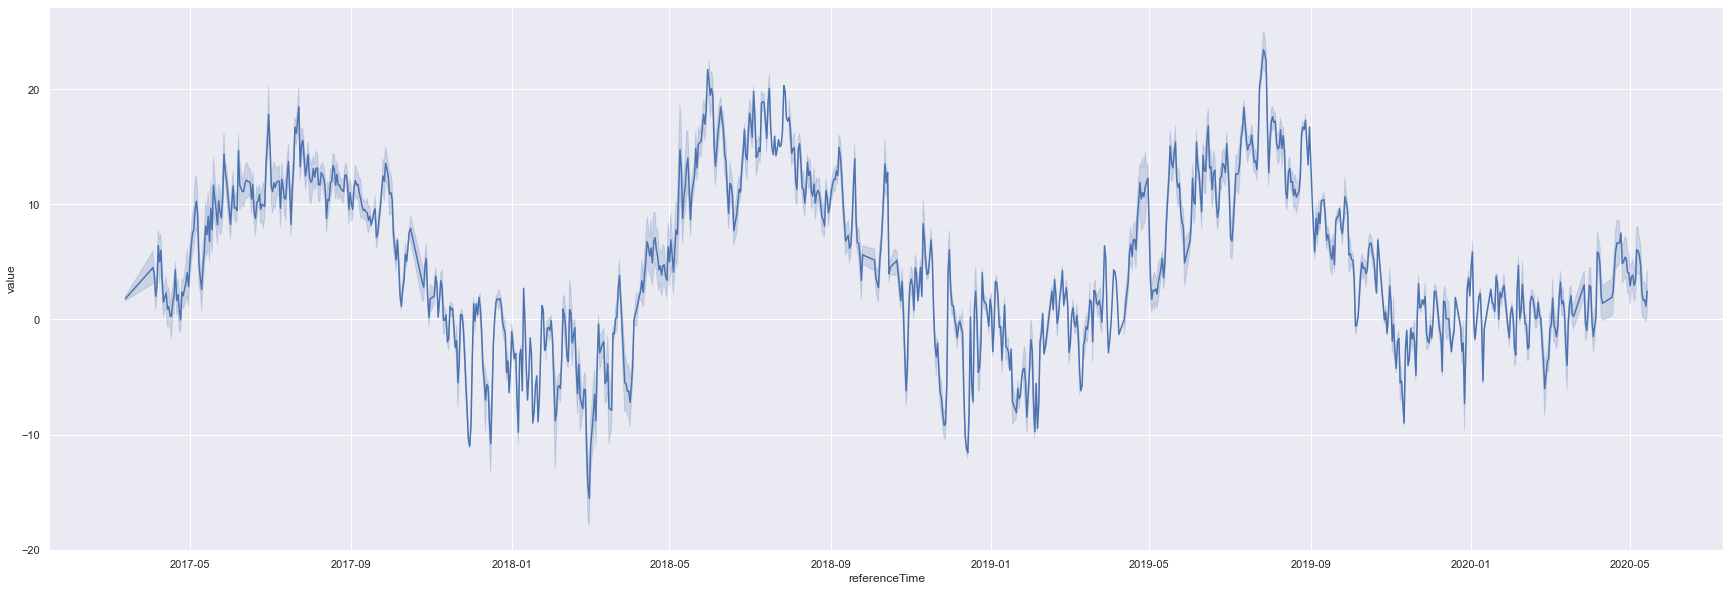

In [36]:
graphelement(source='SN55705,SN55735', elements= 'mean(air_temperature P1D)',referencetime= '2017-01-01/2020-05-15',rollingmean=1)

In [551]:
# Define endpoint and parameters
endpoint = 'https://frost.met.no/sources/v0.jsonld?types=SensorSystem&country=*&municipality=Lillest*'
# endpoint = 'https://frost.met.no/sources/v0.jsonld?types=SensorSystem&municipality=Lillest*'
# endpoint = 'https://frost.met.no/sources/v0.jsonld?ids=SN4260&types=SensorSystem'
# endpoint = 'https://frost.met.no/sources/v0.jsonld?types=SensorSystem&geometry=POLYGON ((11.3 60.03,10.99 59.95, 11.51 59.88, 11.3 60.03))'
# endpoint = 'https://frost.met.no/sources/v0.jsonld?types=SensorSystem&geometry=nearest(POINT(10 60))'
# https://frost.met.no/sources/v0.jsonld?types=SensorSystem&validtime=1900-01-01/1905-01-01 

# endpoint = 'https://frost.met.no/observations/availableTimeSeries/v0.jsonld?sources=SN18700&referencetime=2000-01-01'
# endpoint = 'https://frost.met.no/observations/availableTimeSeries/v0.jsonld?referencetime=1945-01-01/1950-01-01&elements=mean(air_temperature P1M)'
# endpoint = 'https://frost.met.no/observations/availableTimeSeries/v0.jsonld?referencetime=1800-01-01/1899-01-01'

# endpoint = 'https://frost.met.no/frequencies/rainfall/v0.jsonld?sources=SN18701'

r = requests.get(endpoint, auth=(client_id,''))
# Extract JSON data
json = r.json()

# Check if the request worked, print out any errors
if r.status_code == 200:
    data = json['data']
    print('Data retrieved from frost.met.no!\n')
    print(data[0])
    # print('\n',data[1])
    # listsource = [data[i]['id'] for i in range(len(data))]
    # print('\n',listsource)
else:
    print('Error! Returned status code %s' % r.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])

Data retrieved from frost.met.no!

{'@type': 'SensorSystem', 'id': 'SN4820', 'name': 'FETSUND', 'country': 'Norge', 'countryCode': 'NO', 'geometry': {'@type': 'Point', 'coordinates': [11.17, 59.92], 'nearest': False}, 'masl': 120, 'validFrom': '1500-01-01T00:00:00.000Z', 'county': 'VIKEN', 'countyId': 30, 'municipality': 'LILLESTRØM', 'municipalityId': 3030, 'stationHolders': []}


In [267]:
listwind=[]

for source in listsource:
    endpoint = 'https://frost.met.no/observations/availableTimeSeries/v0.jsonld?sources='+ source

    r = requests.get(endpoint, auth=(client_id,''))
    # Extract JSON data
    json = r.json()
    # Check if the request worked, print out any errors
    print('\n')
    if r.status_code == 200:
        data = json['data']
        # print('Data retrieved from frost.met.no!\n')
        for i in range(len(data)):
            if 'wind' in data[i]['elementId']:
                listwind.append(source)
                print(data[i]['sourceId'],data[i]['elementId'])
    else:
        print('Error! Returned status code %s' % r.status_code)
        print('Message: %s' % json['error']['message'])
        print('Reason: %s' % json['error']['reason'])

print(np.unique(listwind))







SN18265:0 wind_speed
SN18265:0 wind_from_direction


SN4260:0 mean(wind_speed P1M)
SN4260:0 max(wind_speed P1M)
SN4260:0 mean(wind_speed P1D)
SN4260:0 min(wind_speed P1M)
SN4260:0 max(wind_speed P1D)
SN4260:0 wind_speed
SN4260:0 wind_speed
SN4260:0 min(wind_speed P1D)


SN4200:0 min(max(wind_speed P1D) P1M)
SN4200:0 max(wind_speed PT1H)
SN4200:0 over_time(time_of_maximum_wind_speed_of_gust PT1H)
SN4200:0 max(max(wind_speed PT1H) P1D)
SN4200:0 mean(wind_speed P1M)
SN4200:0 wind_from_direction
SN4200:0 min(wind_speed P1D)
SN4200:0 max(wind_speed P1D)
SN4200:0 min(max(wind_speed PT1H) P1D)
SN4200:0 mean(wind_speed P1D)
SN4200:0 mean(max(wind_speed P1D) P1M)
SN4200:0 max(wind_speed_of_gust PT1H)
SN4200:0 max(wind_speed_of_gust P1M)
SN4200:0 min(wind_speed_of_gust P1M)
SN4200:0 mean(wind_speed_of_gust P1D)
SN4200:0 over_time(time_of_maximum_wind_speed P1M)
SN4200:0 min(wind_speed_of_gust P1D)
SN4200:0 max(max(wind_speed P1D) P1M)
SN4200:0 mean(max(wind_speed PT1H) P1D)
SN4200:0 max(wi

In [481]:
# Define endpoint and parameters
endpoint2 = 'https://frost.met.no/observations/v0.jsonld'
parameters2 = {
    'sources': 'SN4200',
    'elements': 'wind_from_direction, mean(wind_speed P1D)',
    'referencetime': '2017-05-01/2020-05-01',
}
# Issue an HTTP GET request
r2 = requests.get(endpoint2, parameters2, auth=(client_id,''))
# Extract JSON data
json2 = r2.json()

# Check if the request worked, print out any errors
if r2.status_code == 200:
    data2 = json2['data']
    print('Data retrieved from frost.met.no!')
    print(data2[:2])
else:
    print('Error! Returned status code %s' % r2.status_code)
    print('Message: %s' % json2['error']['message'])
    print('Reason: %s' % json2['error']['reason'])

Data retrieved from frost.met.no!
[{'sourceId': 'SN4200:0', 'referenceTime': '2017-05-01T00:00:00.000Z', 'observations': [{'elementId': 'wind_from_direction', 'value': 207, 'unit': 'degrees', 'level': {'levelType': 'height_above_ground', 'unit': 'm', 'value': 10}, 'timeOffset': 'PT0H', 'timeResolution': 'PT1H', 'timeSeriesId': 0, 'performanceCategory': 'C', 'exposureCategory': '2', 'qualityCode': 0}, {'elementId': 'mean(wind_speed P1D)', 'value': 1.8, 'unit': 'm/s', 'level': {'levelType': 'height_above_ground', 'unit': 'm', 'value': 10}, 'timeOffset': 'PT0H', 'timeResolution': 'P1D', 'timeSeriesId': 0, 'performanceCategory': 'C', 'exposureCategory': '2', 'qualityCode': 2}]}, {'sourceId': 'SN4200:0', 'referenceTime': '2017-05-01T01:00:00.000Z', 'observations': [{'elementId': 'wind_from_direction', 'value': 0, 'unit': 'degrees', 'level': {'levelType': 'height_above_ground', 'unit': 'm', 'value': 10}, 'timeOffset': 'PT0H', 'timeResolution': 'PT1H', 'timeSeriesId': 0, 'performanceCategory'

In [443]:
data2[0]

{'sourceId': 'SN4200:0',
 'referenceTime': '2020-04-01T00:00:00.000Z',
 'observations': [{'elementId': 'wind_from_direction',
   'value': 152,
   'unit': 'degrees',
   'level': {'levelType': 'height_above_ground', 'unit': 'm', 'value': 10},
   'timeOffset': 'PT0H',
   'timeResolution': 'PT1H',
   'timeSeriesId': 0,
   'performanceCategory': 'C',
   'exposureCategory': '2',
   'qualityCode': 0},
  {'elementId': 'mean(wind_speed P1D)',
   'value': 2.8,
   'unit': 'm/s',
   'level': {'levelType': 'height_above_ground', 'unit': 'm', 'value': 10},
   'timeOffset': 'PT0H',
   'timeResolution': 'P1D',
   'timeSeriesId': 0,
   'performanceCategory': 'C',
   'exposureCategory': '2',
   'qualityCode': 2}]}

In [477]:
data2[0]['observations'][1]

{'elementId': 'mean(wind_speed P1D)',
 'value': 2.8,
 'unit': 'm/s',
 'level': {'levelType': 'height_above_ground', 'unit': 'm', 'value': 10},
 'timeOffset': 'PT0H',
 'timeResolution': 'P1D',
 'timeSeriesId': 0,
 'performanceCategory': 'C',
 'exposureCategory': '2',
 'qualityCode': 2}

In [535]:
# This will return a Dataframe with all of the observations in a table format
df2 = pd.DataFrame()
df3 = pd.DataFrame()
for i in range(0,len(data2)):
    if len(data2[i]['observations']) == 1:    
        row2 = pd.DataFrame(data2[i]['observations'])
        row2['referenceTime'] = data2[i]['referenceTime']
        row2['sourceId'] = data2[i]['sourceId']
        df2 = df2.append(row2)
    else:
        row2 = pd.DataFrame(data2[i]['observations'][0])
        row3 = pd.DataFrame(data2[i]['observations'][1])
        row2['referenceTime'] = data2[i]['referenceTime']
        row2['sourceId'] = data2[i]['sourceId']
        df2 = df2.append(row2)
        row3['referenceTime'] = data2[i]['referenceTime']
        row3['sourceId'] = data2[i]['sourceId']
        df3 = df3.append(row3)
df2=df2[::3]
df2 = df2.reset_index()[['referenceTime','value']]
df2['referenceTime'] = [datetime.strptime(each, '%Y-%m-%dT%H:%M:%S.%fZ') for each in df2['referenceTime']]

df3=df3[::3]
df3 = df3.reset_index()[['referenceTime','value']]
df3['referenceTime'] = [datetime.strptime(each, '%Y-%m-%dT%H:%M:%S.%fZ') for each in df3['referenceTime']]

In [487]:
df2[:6]

,referenceTime,value
0,2017-05-01 00:00:00,207.0
1,2017-05-01 01:00:00,0.0
2,2017-05-01 04:00:00,207.0
3,2017-05-01 07:00:00,296.0
4,2017-05-01 10:00:00,227.0
5,2017-05-01 13:00:00,295.0


In [513]:
temp=[]
temp2=[]
temp3=[]
for each in df2['referenceTime']:
    temp.append(each.month)
    temp2.append(each.day)
    temp3.append(each.year)
df2['month']=temp
df2['day']=temp2
df2['year']=temp3

temp=[]
temp2=[]
temp3=[]
for each in df3['referenceTime']:
    temp.append(each.month)
    temp2.append(each.day)
    temp3.append(each.year)
df3['month']=temp
df3['day']=temp2
df3['year']=temp3

In [525]:
df2p1d=df2.groupby(['year','month','day']).mean()
df2p1d['windspeed']=df3.groupby(['year','month','day']).mean()['value']

In [527]:
direc=[]
for each in df2p1d['value']:
    if (0 >= int(each) <= 44):
        direc.append('N')
    elif (45 >= int(each) <= 134):
        direc.append('E')
    elif (135 >= int(each) <= 224):
        direc.append('S')
    elif (225 >= int(each) <= 315):
        direc.append('W')
    else:
        direc.append('N')

print(len(direc),len(df2p1d))
df2p1d['direc']=direc

1087 1087


In [532]:
df2p1d

value  windspeed direc
year month day                             
2017 5     1    237.111111        1.8     N
           2    147.777778        2.1     W
           3     68.250000        2.8     S
           4    120.444444        2.8     S
           5    143.888889        3.1     W
...                    ...        ...   ...
2020 4     26   142.000000        2.4     W
           27    83.375000        3.5     S
           28   111.666667        3.4     S
           29   222.000000        2.0     W
           30    78.875000        4.2     S

[1087 rows x 3 columns]

In [534]:
df2p1d.groupby(['direc']).mean()

,value,windspeed
direc,,
E,30.653395,2.985714
N,244.102673,2.336022
S,97.562778,2.470536
W,186.942614,2.330346


In [529]:
df2p1d[df2p1d['month']==5]['direc'].value_counts()

KeyError: 'month'

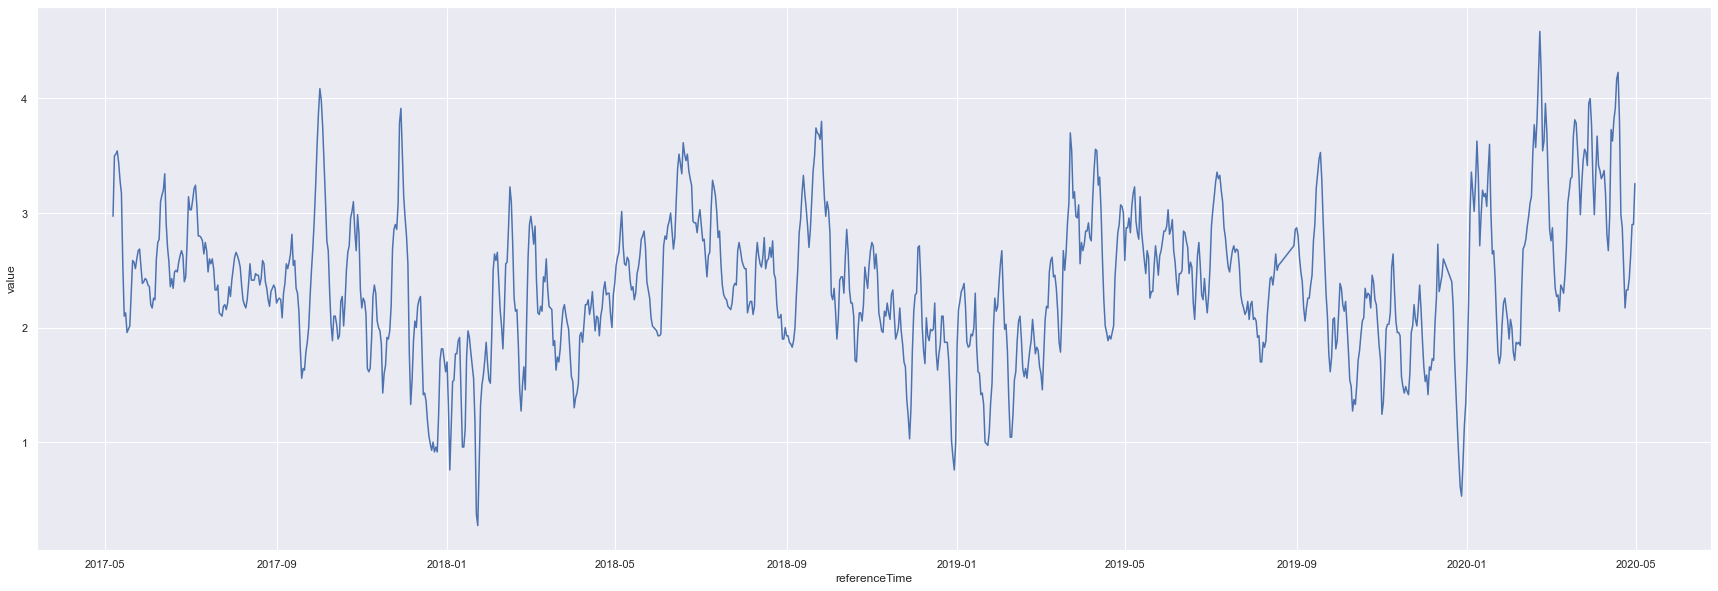

In [486]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

dfplot=df3.copy()
dfplot['value']=df3['value'].rolling(7).mean()

plt.figure(figsize=(30,10))
ax = sns.lineplot(x="referenceTime", y="value", data=dfplot)